# 4. Implementación Matricial de MCO
En esta etapa se utilizaran los datos previamente preparados para el planteamiento del modelo por MCO, utilizando su forma matricial, comparandolo con los resiudalsultados arrojados por la libreria statsmodels.OLS y junto con ello la validacion de supuetos que acompañan la teoria.

## 4.1. Importacion de librerias

In [1]:
# Librerías científicas básicas
import numpy as np
import pandas as pd
import scipy.stats as stats

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos estadísticos
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import OLS, add_constant
 
# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

## 4.2. Lectura de datos

In [2]:
df = pd.read_csv('../data/hour_clean.csv', sep =";")

## 4.3 Split data set (Training and test)
En este apartado separaremos los datos en un 70% para entremaniento de los modelos y un 30% para testing de los mismos.

In [3]:
np.random.seed(0)
train, test = train_test_split(df, train_size=0.7, test_size=0.3, random_state=42) ## aqui separamos uno en 70% del data set y otro 30%, la separacion es aleatoria
print("tamaño set de entrenemaiento ", train.shape)
print("tamaño set de prueba ", test.shape)

tamaño set de entrenemaiento  (12165, 20)
tamaño set de prueba  (5214, 20)


## 4.4 cosntruccion de matrices $X$ y $y$

Para el modelo lineal clasisco expresiudalsado como:
$$
Y = X\beta + \varepsilon
$$

- \(Y\): vector de variables dependientes 
- \(X\): matriz de regresiudalsoresiudals  
- \(\beta\): vector de parámetros
- \(\varepsilon\): vector de erroresiudals

Luego de la minimizacion de cuadrados, los coeficientes se estiman de la forma: 

$$
\hat{\beta} = (X^{\top}X)^{-1}X^{\top}y
$$

In [4]:
# 1. Definir X e y
y = train["cnt"]
X = train.drop(columns=["cnt"])

# convertir booleanos y objetos en numéricos
X = X.apply(pd.to_numeric, errors='coerce')

# eliminar filas con NaN
train_ols = pd.concat([X, y], axis=1).dropna()
y = train_ols["cnt"]
X = train_ols.drop(columns=["cnt"])

X = X.astype(float) ## Matriz X

Antes de ajustar el modelo, aplicaremos el metodo RFE(Recursive Feature Elimination) el cual busca, luego de iteraciones, entregar las variables que mejor explican el modelo maximizando el ajuste

In [5]:
# 2 definamos, utilizando RFE (Recursive Feature Elimination) con el cual elegiremos las mejoresiudals variables para el modelo MCO
model = LinearRegression()
rfe = RFE(estimator=model, n_features_to_select=15)
rfe =rfe.fit(X,y)

print("Variables seleccionadas:")
print("===================")
list(zip(X.columns, rfe.support_))


Variables seleccionadas:


[('yr', np.True_),
 ('temp', np.True_),
 ('hum', np.True_),
 ('windspeed', np.True_),
 ('peak_hour', np.True_),
 ('hr_sin', np.True_),
 ('hr_cos', np.True_),
 ('month_sin', np.True_),
 ('month_cos', np.False_),
 ('weekday_sin', np.False_),
 ('weekday_cos', np.False_),
 ('season_2', np.True_),
 ('season_3', np.True_),
 ('season_4', np.True_),
 ('weathersit_2', np.True_),
 ('weathersit_3', np.True_),
 ('weathersit_4', np.True_),
 ('workingday_1', np.False_),
 ('holiday_1', np.True_)]

In [6]:
print("Ranking de importancia:")
print("===================")
list(zip(X.columns, rfe.ranking_))

Ranking de importancia:


[('yr', np.int64(1)),
 ('temp', np.int64(1)),
 ('hum', np.int64(1)),
 ('windspeed', np.int64(1)),
 ('peak_hour', np.int64(1)),
 ('hr_sin', np.int64(1)),
 ('hr_cos', np.int64(1)),
 ('month_sin', np.int64(1)),
 ('month_cos', np.int64(2)),
 ('weekday_sin', np.int64(4)),
 ('weekday_cos', np.int64(3)),
 ('season_2', np.int64(1)),
 ('season_3', np.int64(1)),
 ('season_4', np.int64(1)),
 ('weathersit_2', np.int64(1)),
 ('weathersit_3', np.int64(1)),
 ('weathersit_4', np.int64(1)),
 ('workingday_1', np.int64(5)),
 ('holiday_1', np.int64(1))]

Seguido del paso anterior nos quedaremos con aquellas variables que se marcaron como importantes para el analisis RFE

In [7]:
X.columns[rfe.support_]

Index(['yr', 'temp', 'hum', 'windspeed', 'peak_hour', 'hr_sin', 'hr_cos',
       'month_sin', 'season_2', 'season_3', 'season_4', 'weathersit_2',
       'weathersit_3', 'weathersit_4', 'holiday_1'],
      dtype='object')

In [8]:
# 3. Filtrar variables resiudalsultado RFE
lista_var = list(X.columns[rfe.support_])
#lista_var.remove('atemp')
#lista_var.remove('weathersit_4')
 
# 4. Construir matriz X con intercepto
X_np = train_ols[lista_var].to_numpy().astype(float)
X_np = np.column_stack([np.ones(X_np.shape[0]), X_np])  # columna de unos
 
# 5. Calcular el VIF de las variables seleccionadas
vif_1 = pd.DataFrame()
vif_1['variables'] = ['const'] + lista_var  # incluir intercepto
vif_1['VIF'] = [variance_inflation_factor(X_np, i) for i in range(X_np.shape[1])]
 
# Ordenar por VIF
vif_1 = vif_1.sort_values(by='VIF', ascending=False)
vif_1

,variables,VIF
0,const,44.136806
10,season_3,6.221751
8,month_sin,4.889820
11,season_4,4.058519
2,temp,3.266916
9,season_2,2.526276
3,hum,1.828823
6,hr_sin,1.350040
13,weathersit_3,1.298186
7,hr_cos,1.265502


Eliminamos Weekend, y nos quedamos solo con holiday y working day, ya que con estas se captura de manera menos redundante si es dia de semana (trabajo) o fin de semana.

## 4.5 Calculo de Coeficientes Regresion

In [9]:
X_np = train_ols[['yr', 'temp', 'hum', 'windspeed', 'peak_hour', 'hr_sin', 'hr_cos',
       'month_sin', 'season_2', 'season_3', 'season_4', 'weathersit_2',
       'weathersit_3', 'weathersit_4', 'holiday_1']].to_numpy().astype(float)
X_np = np.column_stack([np.ones(X_np.shape[0]), X_np])  # columna de unos
# 4. Aplicar ecuación normal
XtX = X_np.T @ X_np
XtY = X_np.T @ y
beta_manual = np.linalg.pinv(XtX) @ XtY
print("Coeficientes (ecuación normal):", beta_manual.flatten())

Coeficientes (ecuación normal): [  23.27253813   86.3031409   224.50128708  -68.24800661  -37.29548918
  160.83287692  -83.49485622  -74.83648406   -9.00851546   45.13702782
   23.0071998    56.83758396  -13.16368955  -64.49499568 -117.21571885
  -32.36380396]


Ahora utilizaremos OLS de Statmodels, para la generacion de los coeficientes de la regresion

In [10]:
# 6. Ajustar OLS con statsmodels
X_sm = add_constant(train_ols[['yr', 'temp', 'hum', 'windspeed', 'peak_hour', 'hr_sin', 'hr_cos',
       'month_sin', 'season_2', 'season_3', 'season_4', 'weathersit_2',
       'weathersit_3', 'weathersit_4', 'holiday_1']].astype(float))
ols_model = OLS(y, X_sm).fit()
beta_ols = ols_model.params
print("===============")
print("Coeficientes (OLS statsmodels):\n", beta_ols)

Coeficientes (OLS statsmodels):
 const            23.272538
yr               86.303141
temp            224.501287
hum             -68.248007
windspeed       -37.295489
peak_hour       160.832877
hr_sin          -83.494856
hr_cos          -74.836484
month_sin        -9.008515
season_2         45.137028
season_3         23.007200
season_4         56.837584
weathersit_2    -13.163690
weathersit_3    -64.494996
weathersit_4   -117.215719
holiday_1       -32.363804
dtype: float64


In [11]:
# 6. Comparar en tabla
coef_table = pd.DataFrame({
    "Variable": ["Intercepto"] + ['yr', 'temp', 'hum', 'windspeed', 'peak_hour', 'hr_sin', 'hr_cos',
       'month_sin', 'season_2', 'season_3', 'season_4', 'weathersit_2',
       'weathersit_3', 'weathersit_4', 'holiday_1'],
    "Beta (Ecuación Normal)": beta_manual.flatten(),
    "Beta (OLS Statsmodels)": beta_ols.values
})

print("\nTabla comparativa de coeficientes:")
coef_table


Tabla comparativa de coeficientes:


,Variable,Beta (Ecuación Normal),Beta (OLS Statsmodels)
0,Intercepto,23.272538,23.272538
1,yr,86.303141,86.303141
2,temp,224.501287,224.501287
3,hum,-68.248007,-68.248007
4,windspeed,-37.295489,-37.295489
5,peak_hour,160.832877,160.832877
6,hr_sin,-83.494856,-83.494856
7,hr_cos,-74.836484,-74.836484
8,month_sin,-9.008515,-9.008515
9,season_2,45.137028,45.137028


## 4.6. Interpretación de coeficientes OLS – Alquiler de bicicletas
### 3.6.1. Tabla de coeficientes

| Variable       | Coeficiente | Interpretación económica/urbana |
|----------------|-------------|---------------------------------
| cost           | 23.27       | Nivel base de alquileresiudals cuando todas las variables están en cero. Represiudalsenta la demanda mínima esperada.|
| yr             | 86.30       | La demanda aumenta con el paso de los años, reflejando una tendencia creciente en el uso de bicicletas |
| temp           | 224.50      | A mayor temperatura, la demanda crece significativamente. El clima cálido incentiva la movilidad en biciclet. |
| hum            | -68.25      | La humedad elevada reduce la demanda, asociada a incomodidad y posibles lluvis. |
| windspeed      | -37.30      | A mayor velocidad del viento, disminuye el uso de bicicletas por condiciones adveras. |
| peak_hour      | 160.83      | En horas pico la demanda aumenta de forma marcada, reflejando desplazamientos laborales y escolresiudals. |
| hr_sin         | -83.49      | Captura el ciclo horario: valoresiudals negativos indican menor demanda en ciertas horas de día. |
| hr_cos         | -74.84      | Complementa el patrón horario, mostrando variaciones cíclicas a lo largo dl día. |
| month_sin      | -9.01       | Refleja la estacionalidad anual: menor demanda en ciertos meses (ej. fríos o lluiosos). |
| season_2       | 45.14       | En primavera/verano la demanda aumenta, asociada a condiciones climáticas faorables. |
| season_3       | 23.01       | En otoño la demanda también crece, aunque en menor medida que n verano. |
| season_4       | 56.84       | En invierno la demanda se incrementa en comparación con la base, posiblemente por hábitos urbanos epecíficos. |
| weathersit_2   | -13.16      | Clima nublado reduce la demanda resiudalspecto a díasdespejados. |
| weathersit_3   | -64.49      | Lluvia ligera disminuye fuertement la demanda. |
| weathersit_4   | -117.22     | Lluvia fuerte desploma la demanda, mostrando alta sensibildad al clima. |
| holiday_1      | -32.36      | En días festivos la demanda cae, probablemente por menor mo o de clima adverso.|

## Síntesis económica y urbana
 
El modelo confirma que la **demanda de bicicletas está determinada por factoresiudals climáticos, temporales y estacionales**.   
- **Clima**: la temperatura impulsa fuertemente la demanda, mientras que la humedad, el viento y la lluvia la reducen.  
- **Tiempo**: las horas pico y los días laborales son los principales motoresiudals de la movilidad en bicicleta.  
- **Estacionalidad**: la demanda aumenta en primavera, verano y otoño, mostrando patrones de uso ligados al clima.  
- **Tendencia temporal**: el crecimiento interanual refleja una mayor adopción del sistema de bicicletas en la ciudad.  
- **Festivos**: la caída en días festivos sugiere que la movilidad laboral es el principal determinante de la demanda, con el ocio como complemento.  

En términos de planificación urbana, esto implica que el sistema de alquiler debe considerar tanto la **variabilidad climática** como los **patrones de movilidad laboral y estacional**, reforzando la disponibilidad en horas pico y temporadas favorables, y anticipando caídas en días festivos o de clima adverso.

In [12]:
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     1461.
Date:                Fri, 28 Nov 2025   Prob (F-statistic):               0.00
Time:                        17:23:15   Log-Likelihood:                -74356.
No. Observations:               12165   AIC:                         1.487e+05
Df Residuals:                   12149   BIC:                         1.489e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           23.2725      6.583      3.535   

Extraemos weathersit_4 ya que no es estadisticamene significativo

In [13]:
# 7. Ajustar OLS con statsmodels con todas las variables finales
X_sm = add_constant(train_ols[['yr', 'temp', 'hum', 'windspeed', 'peak_hour', 'hr_sin', 'hr_cos',
       'month_sin', 'season_2', 'season_3', 'season_4', 'weathersit_2',
       'weathersit_3', 'holiday_1']].astype(float))
ols_model = OLS(y, X_sm).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     1565.
Date:                Fri, 28 Nov 2025   Prob (F-statistic):               0.00
Time:                        17:23:15   Log-Likelihood:                -74357.
No. Observations:               12165   AIC:                         1.487e+05
Df Residuals:                   12150   BIC:                         1.489e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           23.3316      6.583      3.544   

## 4.7. Diagnostico de supuestos del modelo
En esta seccion, a partir del modelo anterior, se revisara elñ cumplimiento de la teoria sobre los errores, para entender si el modelo es valido o no

### 4.7.1. Revision de residuos (Normalidad, Homocedasticidad e independencia)

Se parte de la inspeccion visual de residuos
- Disribucion de residuos
- Q-Q Plot de residuos
- Densiad de residuales

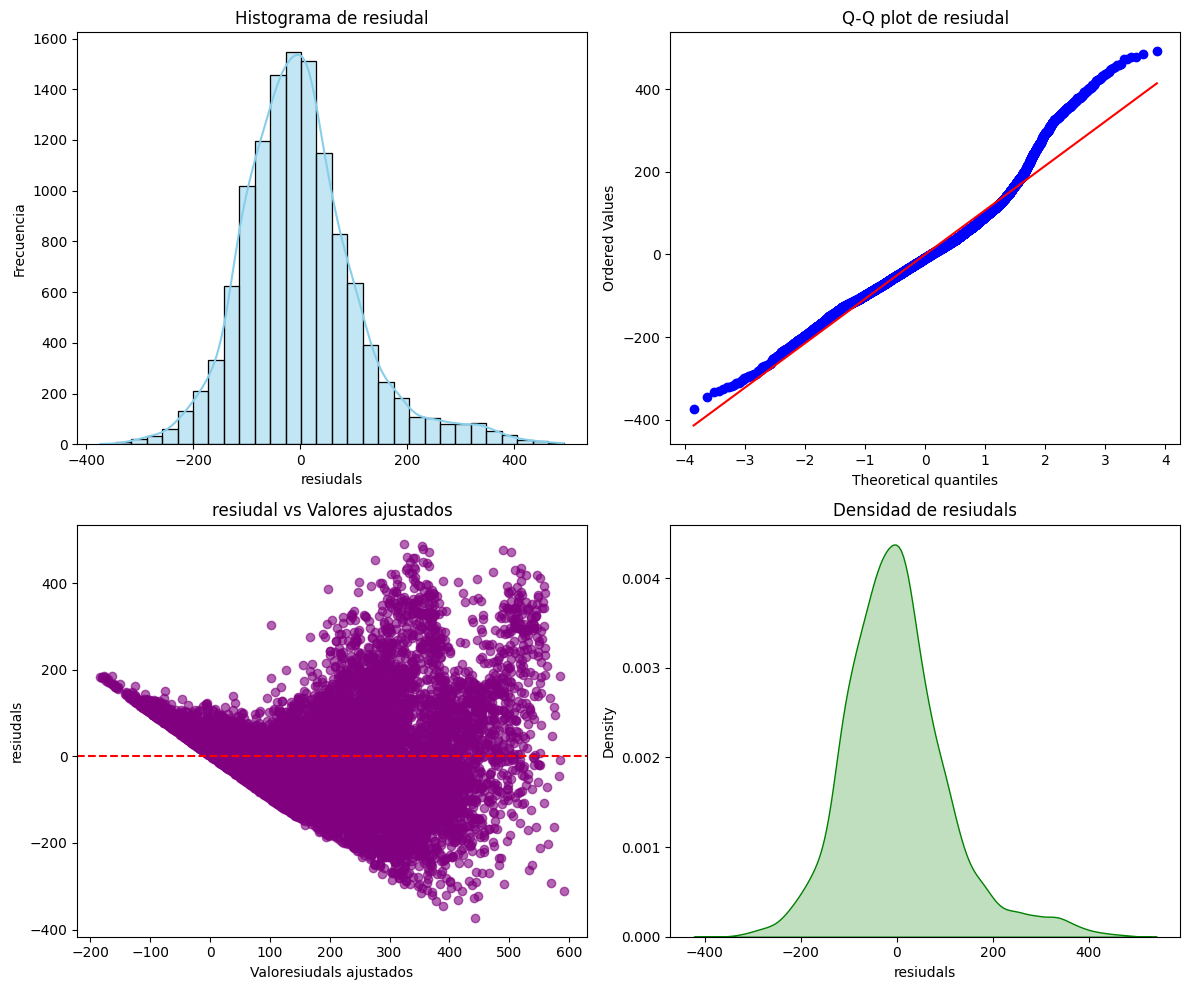

In [14]:
## Generacion de resiudals

fitted_values = ols_model.fittedvalues
residuals = ols_model.resid

## Particion de grafica
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
 
# 1. Histograma de resiudal
sns.histplot(residuals, kde=True, bins=30, color="skyblue", ax=axes[0,0])
axes[0,0].set_title("Histograma de resiudal")
axes[0,0].set_xlabel("resiudals")
axes[0,0].set_ylabel("Frecuencia")
 
# 2. Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[0,1])
axes[0,1].set_title("Q-Q plot de resiudal")
 
# 3. resiudals vs valores ajustados
axes[1,0].scatter(fitted_values, residuals, alpha=0.6, color="purple")
axes[1,0].axhline(y=0, color="red", linestyle="--")
axes[1,0].set_title("resiudal vs Valores ajustados")
axes[1,0].set_xlabel("Valoresiudals ajustados")
axes[1,0].set_ylabel("resiudals")

# 4. Densidad de resiudal
sns.kdeplot(residuals, color="green", fill=True, ax=axes[1,1])
axes[1,1].set_title("Densidad de resiudals")
axes[1,1].set_xlabel("resiudals")
plt.tight_layout()

plt.show()
 

Se observa que los residuos forman patrones y que no siguen una distribucion normal, lo cual validaremos con las pruebas estadisticas:
1. Normalidad de residuos (Shapiro-Wilk)
2. Homocedasticidad (Breusch-Pagan)
3. Homocedasticidad (White test)

In [15]:
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro

# 1. Normalidad de residuos (Shapiro-Wilk)
shapiro_test = shapiro(residuals)
print("Shapiro-Wilk Test:")
print("Statistic =", shapiro_test.statistic, "p-value =", shapiro_test.pvalue)
 
# 2. Homocedasticidad (Breusch-Pagan)
bp_test = het_breuschpagan(residuals, ols_model.model.exog)
print("\nBreusch-Pagan Test:")
print("LM stat =", bp_test[0], "p-value =", bp_test[1])
print("F stat =", bp_test[2], "p-value =", bp_test[3])
 
# 3. Homocedasticidad (White test)
white_test = het_white(residuals, ols_model.model.exog)
print("\nWhite Test:")
print("LM stat =", white_test[0], "p-value =", white_test[1])
print("F stat =", white_test[2], "p-value =", white_test[3])
 
# 4. Independencia de residuos (Durbin-Watson)
dw_stat = durbin_watson(residuals)
print("\nDurbin-Watson Test:")
print("Statistic =", dw_stat)

Shapiro-Wilk Test:
Statistic = 0.9639487391174991 p-value = 1.9697052492615185e-47

Breusch-Pagan Test:
LM stat = 2494.5856363046846 p-value = 0.0
F stat = 223.87292638291555 p-value = 0.0

White Test:
LM stat = 3481.048203219777 p-value = 0.0
F stat = 45.59970649558016 p-value = 0.0

Durbin-Watson Test:
Statistic = 2.012892945386459


/home/codespace/.local/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12165.
  res = hypotest_fun_out(*samples, **kwds)


## 4.7.2. Resultados validacion supuestos

**Shapiro-Wilk Test**  
Estadistico = 0.964, p-value = 0.0  
El p-value es extremadamente bajo, por lo tanto **rechazamos la hipótesis nula de normalidad**.  
**Conclusión:** los residuos no siguen una distribución normal. Esto afecta la validez de los intervalos de confianza y tests de significancia clásicos.  
 
**Breusch-Pagan Test**  
Estadistico = 2494.59, p-value = 0.0  
El p-value = 0 indica **heterocedasticidad**.  
**Conclusión:** los residuos no son homocedásticos (la varianza no es constante). Esto puede provocar sesgos en las estimaciones de error estándar del modelo.  
 
**White Test**  
Estadistico = 3480.89, p-value = 0.0  
Confirma lo mismo que Breusch-Pagan, indicando **heterocedasticidad** de los residuos.  
**Conclusión**: hay problemas de varianza no constante en los residuos.  
 
**Durbin-Watson Test**  
Estadistico = 2.01  
Valores cercanos a 2 indican ausencia de autocorrelación.  
**Conclusión:** los residuos no presentan autocorrelación, lo que valida la indeendencia de los residuos.

In [16]:
import pickle

# Guardaremos el modelo en formato .pkl para su posterior utilizacion
with open("ols_model.pkl", "wb") as f:
    pickle.dump(ols_model, f)